In [8]:
# Google Mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 데이터 로드
pre_covid_data = pd.read_csv('/content/drive/My Drive/pre_covid_data.csv', index_col=0, parse_dates=True)
post_covid_data = pd.read_csv('/content/drive/My Drive/post_covid_data.csv', index_col=0, parse_dates=True)

In [10]:
# 중복된 날짜 제거 (post_covid_data)
post_covid_data = post_covid_data[~post_covid_data.index.duplicated(keep='first')]

# 중복 제거 후 확인
print(post_covid_data.loc['2024-01-01'])

passengers            30550.000000
esi                       0.120879
gdp                       0.000000
gdp_growth                0.958333
kr_jp_travel_total        0.767986
                          ...     
esi_lag_2m                0.120879
esi_lag_3m                0.186813
esi_lag_4m                0.296703
esi_lag_5m                0.439560
esi_lag_6m                0.450549
Name: 2024-01-01 00:00:00, Length: 106, dtype: float64


In [11]:
# 중복된 인덱스 확인
print(post_covid_data.index.duplicated().sum())

# 중복된 날짜 확인
print(post_covid_data[post_covid_data.index.duplicated(keep=False)])

0
Empty DataFrame
Columns: [passengers, esi, gdp, gdp_growth, kr_jp_travel_total, kr_jp_travel_tourist, kr_jp_travel_business, kr_jp_travel_others, Average temperature (°C), Average High Temperature (°C), Average minimum temperature (°C), Highest temperature (°C), Lowest temperature (°C), Average local pressure (hPa), Mean sea level pressure (hPa), Maximum sea level pressure (hPa), Minimum sea level pressure (hPa), Average vapor pressure (hPa), Maximum vapor pressure (hPa), Minimum vapor pressure (hPa), Average Dew Point Temperature (°C), Average relative humidity (%), Minimum relative humidity (%), Minimum relative humidity on the day (yyyymmdd), Monthly combined precipitation (00~24h only) (mm), Maximum daily precipitation (mm), Maximum rainfall per hour (mm), Maximum precipitation in 10 minutes (mm), Small total evaporation (mm), Small-scale maximum evaporation (mm), Large total evaporation (mm), Large-scale maximum evaporation (mm), The day when the maximum daily evaporation occurr

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Pre-Covid 모델 (2019) 성능: RMSE = 51786.771537643755 , MAE = 38451.760633680555
Pre-Covid 모델 (2024) 성능: RMSE = 36606.940793331145 , MAE = 24791.29885253906
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1}
Post-Covid 모델 (2024) 성능: RMSE = 51851.31846265698 , MAE = 44335.80648193359


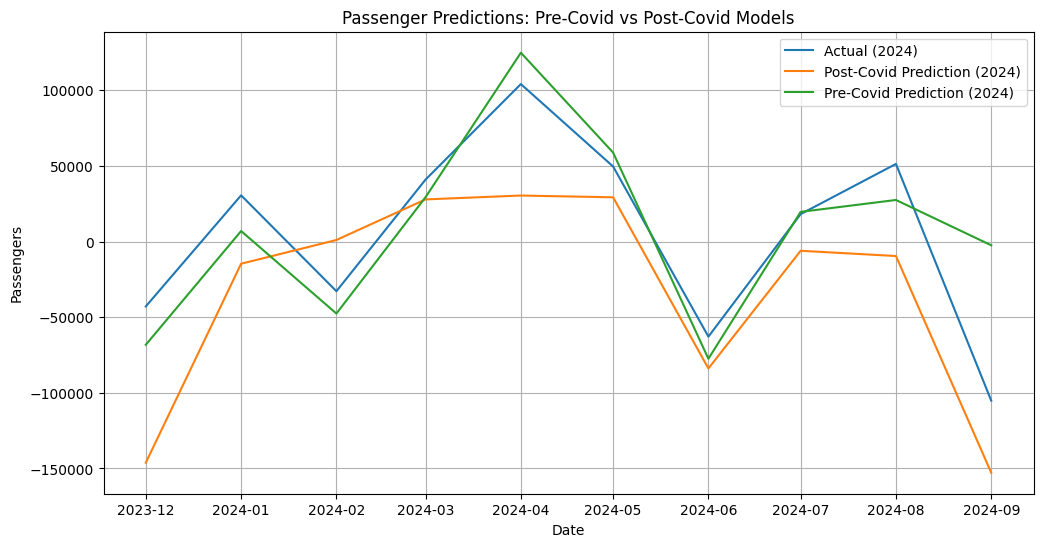

In [12]:
# 1. 데이터 준비
# 데이터 분할
pre_covid_train = pre_covid_data.loc['2004-01-01':'2017-12-31']
pre_covid_val = pre_covid_data.loc['2018-01-01':'2018-12-31']
pre_covid_test_2019 = pre_covid_data.loc['2019-01-01':'2019-09-01']
pre_covid_test_2024 = post_covid_data.loc['2023-12-01':'2024-09-01']

post_covid_train = post_covid_data.loc['2022-06-01':'2023-05-31']
post_covid_val = post_covid_data.loc['2023-06-01':'2023-11-30']
post_covid_test = post_covid_data.loc['2023-12-01':'2024-09-01']

# Feature 선택
def select_features(data, features, target_var):
    return data[features + [target_var]]

# Feature 리스트
pre_covid_selected_features = ['gdp', 'Average temperature (°C)', 'kr_jp_travel_total',
                               'Small total evaporation (mm)', 'esi', 'big_holiday', 'Average cloud cover (1/10)']
post_covid_selected_features = ['Average temperature (°C)', 'Small total evaporation (mm)',
                                'Average cloud cover (1/10)', 'gdp', 'esi', 'big_holiday']

pre_covid_train = select_features(pre_covid_train, pre_covid_selected_features, 'passengers')
pre_covid_val = select_features(pre_covid_val, pre_covid_selected_features, 'passengers')
pre_covid_test_2019 = select_features(pre_covid_test_2019, pre_covid_selected_features, 'passengers')
pre_covid_test_2024 = select_features(pre_covid_test_2024, pre_covid_selected_features, 'passengers')

post_covid_train = select_features(post_covid_train, post_covid_selected_features, 'passengers')
post_covid_val = select_features(post_covid_val, post_covid_selected_features, 'passengers')
post_covid_test = select_features(post_covid_test, post_covid_selected_features, 'passengers')

# 2. 데이터 전처리 및 학습용 데이터 준비
def prepare_data(train, val, test, target_var):
    X_train = train.drop(columns=[target_var])
    y_train = train[target_var]
    X_val = val.drop(columns=[target_var])
    y_val = val[target_var]
    X_test = test.drop(columns=[target_var])
    y_test = test[target_var]
    return X_train, y_train, X_val, y_val, X_test, y_test

# 3. 하이퍼파라미터 최적화 함수
def optimize_xgboost(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1],
        'colsample_bytree': [0.8, 0.9, 1]
    }
    model = XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

# 4. 모델 평가 함수 정의
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return y_pred, rmse, mae

# 5. Pre-Covid 모델 학습 및 평가
target_var = 'passengers'

# Pre-Covid 데이터 준비
X_train, y_train, X_val, y_val, X_test_2019, y_test_2019 = prepare_data(pre_covid_train, pre_covid_val, pre_covid_test_2019, target_var)
X_train, y_train, X_val, y_val, X_test_2024, y_test_2024 = prepare_data(pre_covid_train, pre_covid_val, pre_covid_test_2024, target_var)

# 최적화된 모델 학습
model_pre_covid = optimize_xgboost(X_train, y_train, X_val, y_val)

# 평가
y_pred_pre_2019, rmse_pre_2019, mae_pre_2019 = evaluate_model(model_pre_covid, X_test_2019, y_test_2019)
y_pred_pre_2024, rmse_pre_2024, mae_pre_2024 = evaluate_model(model_pre_covid, X_test_2024, y_test_2024)

# 결과 출력
print("Pre-Covid 모델 (2019) 성능: RMSE =", rmse_pre_2019, ", MAE =", mae_pre_2019)
print("Pre-Covid 모델 (2024) 성능: RMSE =", rmse_pre_2024, ", MAE =", mae_pre_2024)

# 6. Post-Covid 모델 학습 및 평가
X_train, y_train, X_val, y_val, X_test_post, y_test_post = prepare_data(post_covid_train, post_covid_val, post_covid_test, target_var)

# 최적화된 모델 학습
model_post_covid = optimize_xgboost(X_train, y_train, X_val, y_val)

# 평가
y_pred_post, rmse_post, mae_post = evaluate_model(model_post_covid, X_test_post, y_test_post)

# 결과 출력
print("Post-Covid 모델 (2024) 성능: RMSE =", rmse_post, ", MAE =", mae_post)

# 7. 시각화 및 비교
plt.figure(figsize=(12, 6))
plt.plot(y_test_post.index, y_test_post, label="Actual (2024)")
plt.plot(y_test_post.index, y_pred_post, label="Post-Covid Prediction (2024)")
plt.plot(y_test_2024.index, y_pred_pre_2024, label="Pre-Covid Prediction (2024)")
plt.legend()
plt.title("Passenger Predictions: Pre-Covid vs Post-Covid Models")
plt.ylabel("Passengers")
plt.xlabel("Date")
plt.grid()
plt.show()

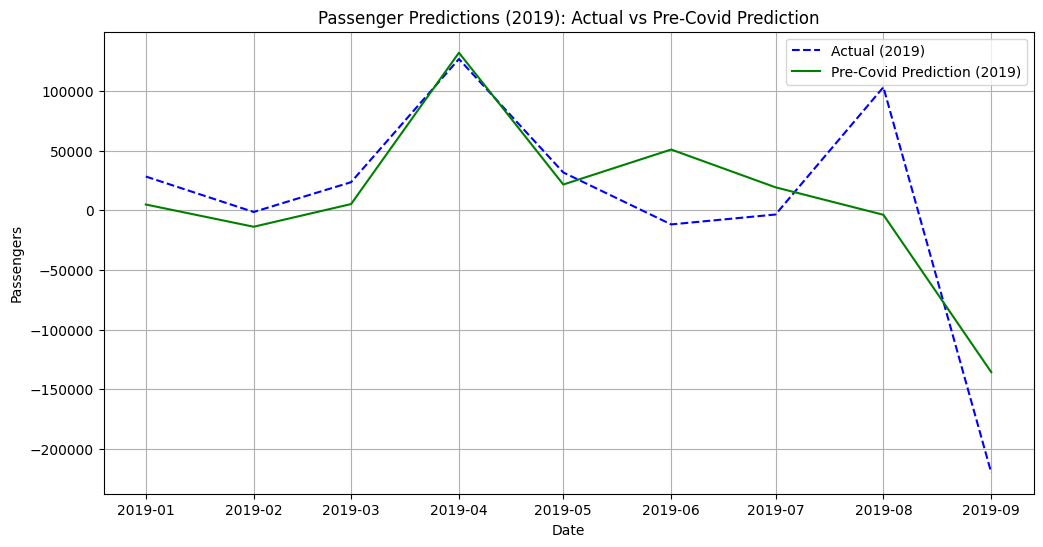

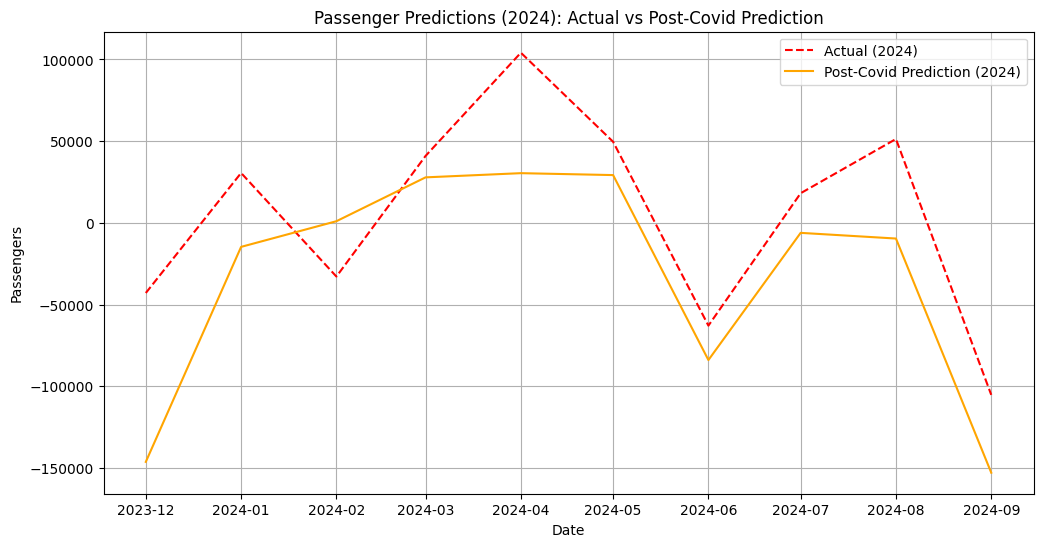

In [14]:
import matplotlib.pyplot as plt

# 2019년 데이터 비교
plt.figure(figsize=(12, 6))
plt.plot(
    y_test_2019.index,
    y_test_2019,
    label="Actual (2019)",
    color='blue',
    linestyle='--'
)
plt.plot(
    y_test_2019.index,
    y_pred_pre_2019,
    label="Pre-Covid Prediction (2019)",
    color='green'
)
plt.title("Passenger Predictions (2019): Actual vs Pre-Covid Prediction")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

# 2024년 데이터 비교
plt.figure(figsize=(12, 6))
plt.plot(
    y_test_post.index,
    y_test_post,
    label="Actual (2024)",
    color='red',
    linestyle='--'
)
plt.plot(
    y_test_post.index,
    y_pred_post,
    label="Post-Covid Prediction (2024)",
    color='orange'
)
plt.title("Passenger Predictions (2024): Actual vs Post-Covid Prediction")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

In [25]:
passenger_data_path = "/content/drive/MyDrive/시계열 통계_20241102.xlsx"
#PREPARING THE PASSENGER DATA

# Load passenger data
passengers_df = pd.read_excel(passenger_data_path, skiprows=7)

# Remove subtotal rows
passengers_df = passengers_df.dropna(subset=[passengers_df.columns[2]])

# Indexing by date
passengers_df[passengers_df.columns[2]] = passengers_df[passengers_df.columns[2]].astype(int)
passengers_df['date'] = passengers_df[passengers_df.columns[1]].astype(str) + '-' + passengers_df[passengers_df.columns[2]].astype(str)
passengers_df['date'] = pd.to_datetime(passengers_df['date'])
passengers_df = passengers_df.set_index('date')

# Only keep target variable: Arriving Passangers to Jeju Airport
passengers_df.rename(columns={passengers_df.columns[6]: 'passengers'}, inplace=True)
passengers_df[passengers_df.columns[6]] = passengers_df[passengers_df.columns[6]].str.replace(',', '').astype(int)
passengers_df = passengers_df[passengers_df.columns[6]]
passengers_df.tail()

,passengers
date,
2024-05-01,1328528
2024-06-01,1265682
2024-07-01,1283827
2024-08-01,1335140
2024-09-01,1229948


In [30]:
# 초기값 설정: 2023-12-01의 실제값 사용
initial_value_2024 = passengers_df.loc['2023-12-01']  # Series이므로 컬럼 인덱스 필요 없음
print("Initial Value at 2023-12-01:", initial_value_2024)

Initial Value at 2023-12-01: 1136114


Initial Value at 2018-12-01: 1140996
Initial Value at 2023-12-01: 1136114


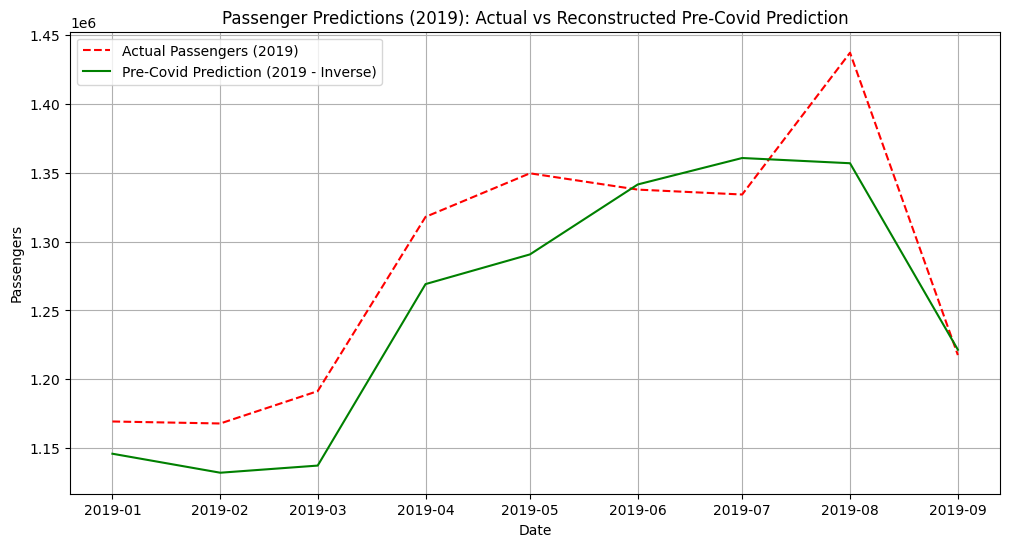

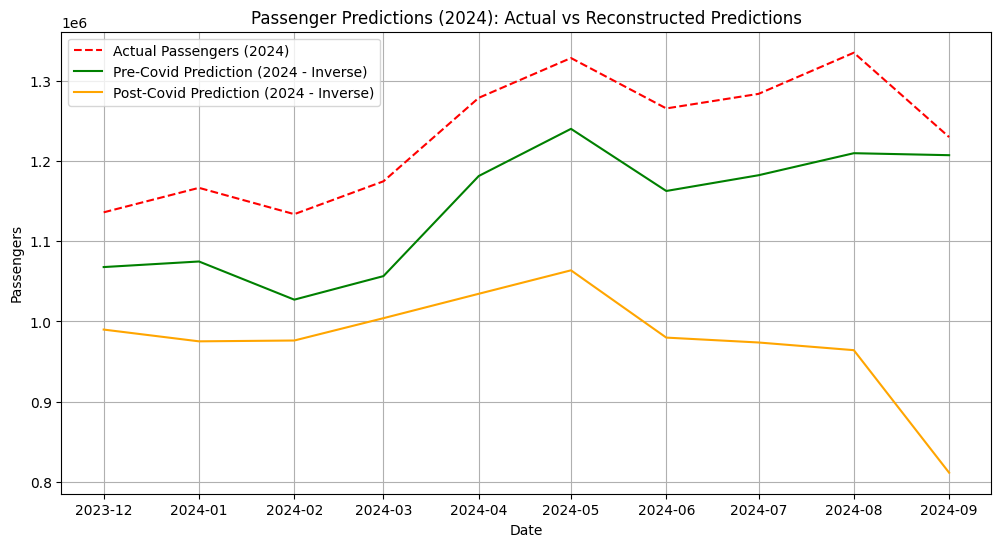

In [33]:
# 초기값 설정: 2018-12-01의 실제값 사용 (2019 예측)
initial_value_2019 = passengers_df.loc['2018-12-01']
initial_value_2024 = passengers_df.loc['2023-12-01']

print("Initial Value at 2018-12-01:", initial_value_2019)
print("Initial Value at 2023-12-01:", initial_value_2024)

# 역차분 함수
def inverse_differencing(differenced, initial_value):
    """
    차분된 예측 값을 원래 스케일로 복원하는 함수.
    :param differenced: 차분된 예측값 리스트 또는 배열
    :param initial_value: 첫 번째 시점의 실제값 (복원 시작점)
    :return: 원래 스케일로 복원된 값
    """
    original = [initial_value]
    differenced = np.ravel(differenced)
    for diff in differenced:
        original.append(original[-1] + diff)
    return np.array(original)

# 역차분 적용
y_pred_pre_2019_inverse = inverse_differencing(y_pred_pre_2019, initial_value_2019)
y_pred_pre_2024_inverse = inverse_differencing(y_pred_pre_2024, initial_value_2024)
y_pred_post_2024_inverse = inverse_differencing(y_pred_post, initial_value_2024)

# 시각화: 2019년 데이터 (실제 값 vs Pre-Covid 예측)
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(
    y_test_2019.index,
    passengers_df.loc[y_test_2019.index],
    label="Actual Passengers (2019)",
    color="red",
    linestyle="--"
)

# Pre-Covid 모델 예측 (역차분 적용 후)
plt.plot(
    y_test_2019.index,
    y_pred_pre_2019_inverse[1:],  # 초기값 제외
    label="Pre-Covid Prediction (2019 - Inverse)",
    color="green"
)

# 그래프 설정
plt.title("Passenger Predictions (2019): Actual vs Reconstructed Pre-Covid Prediction")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

# 시각화: 2024년 데이터 (실제 값 vs Pre-Covid 예측 vs Post-Covid 예측)
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(
    y_test_post.index,
    passengers_df.loc[y_test_post.index],
    label="Actual Passengers (2024)",
    color="red",
    linestyle="--"
)

# Pre-Covid 모델 예측 (역차분 적용 후)
plt.plot(
    y_test_2024.index,
    y_pred_pre_2024_inverse[1:],
    label="Pre-Covid Prediction (2024 - Inverse)",
    color="green"
)

# Post-Covid 모델 예측 (역차분 적용 후)
plt.plot(
    y_test_post.index,
    y_pred_post_2024_inverse[1:],
    label="Post-Covid Prediction (2024 - Inverse)",
    color="orange"
)

# 그래프 설정
plt.title("Passenger Predictions (2024): Actual vs Reconstructed Predictions")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()